1.1 Install Dependencies and Setup

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import random
from tqdm.notebook import tqdm
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D



Load the Dataset

In [2]:
TRAIN_DIR = '../input/facial-expression-datasets/train/train/'
TEST_DIR = '../input/facial-expression-datasets/test/test/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,../input/facial-expression-datasets/train/trai...,sad
1,../input/facial-expression-datasets/train/trai...,surprise
2,../input/facial-expression-datasets/train/trai...,angry
3,../input/facial-expression-datasets/train/trai...,angry
4,../input/facial-expression-datasets/train/trai...,sad


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()


angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,../input/facial-expression-datasets/test/test/...,angry
1,../input/facial-expression-datasets/test/test/...,angry
2,../input/facial-expression-datasets/test/test/...,angry
3,../input/facial-expression-datasets/test/test/...,angry
4,../input/facial-expression-datasets/test/test/...,angry


Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

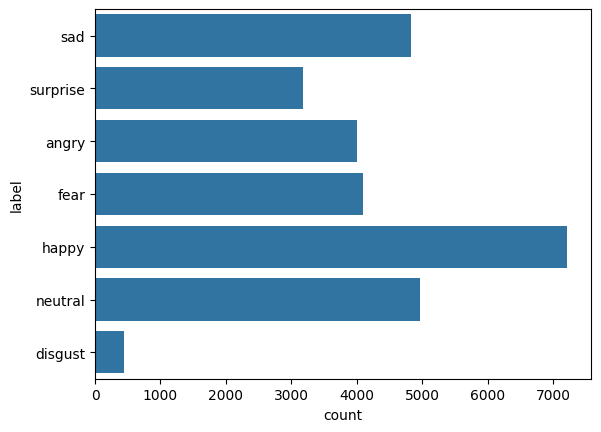

In [6]:
sns.countplot(train['label'])

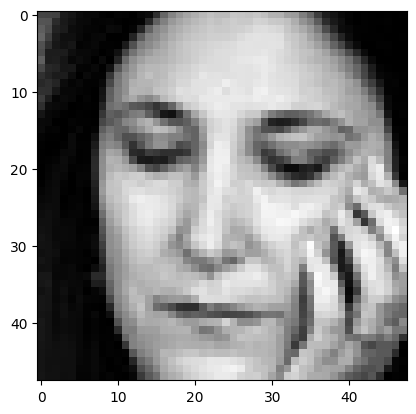

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

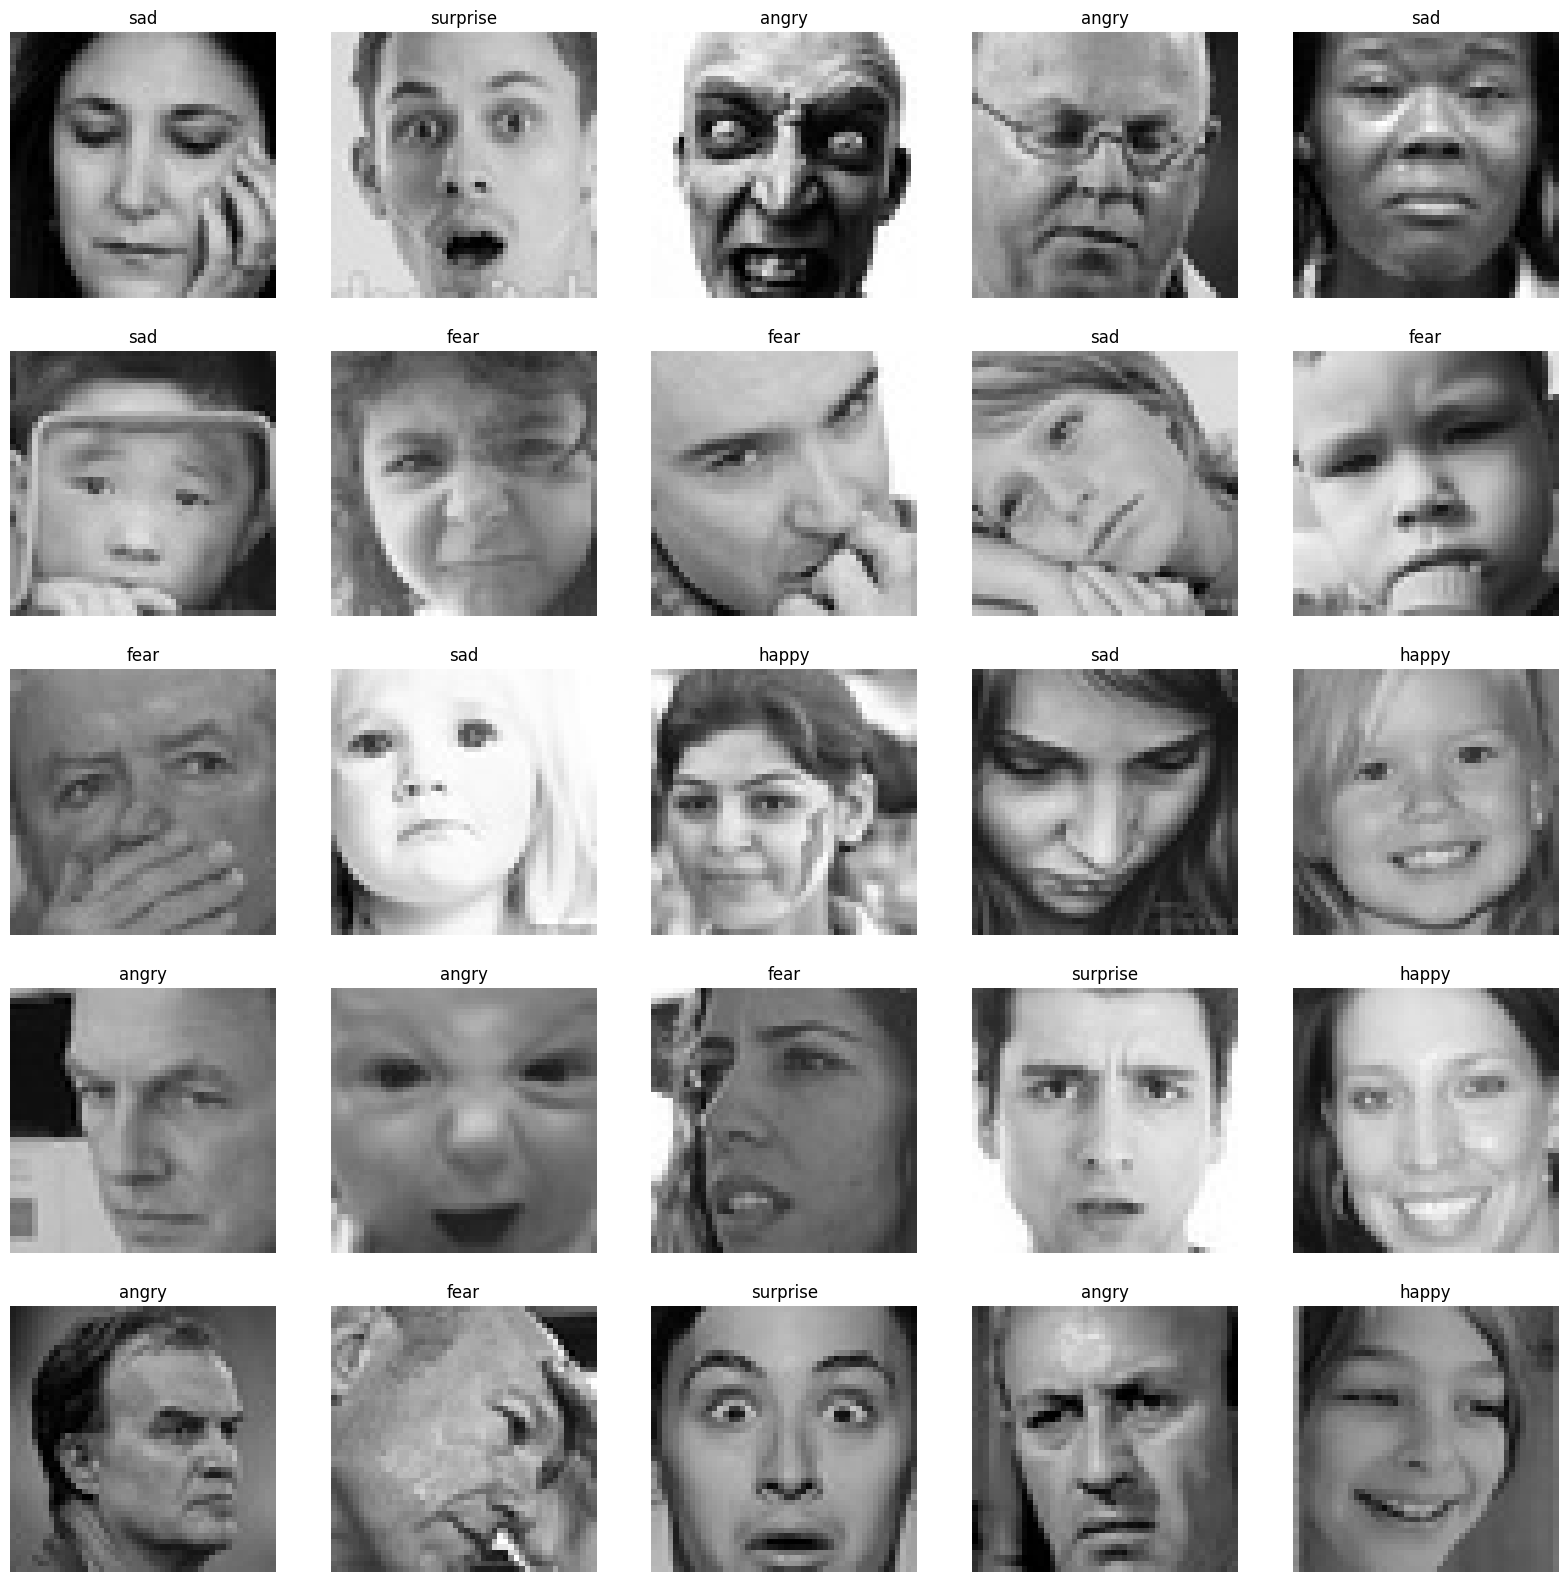

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
from keras.preprocessing.image import load_img


def extract_features(images):
    features = []
    for image in tqdm(images):
        # Use color_mode='grayscale' to load image in grayscale
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        # Process and extract features here
        features.append(img)
    return features

In [11]:
train_features = extract_features(train['image'])

100%|██████████| 28709/28709 [00:07<00:00, 4063.24it/s]


In [12]:
test_features = extract_features(test['image'])

100%|██████████| 7178/7178 [00:01<00:00, 4511.83it/s]


In [13]:

# Convert lists to NumPy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)

# Normalize the images by dividing by 255.0
x_train = train_features / 255.0
x_test = test_features / 255.0


In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [17]:
# config
input_shape = (48, 48, 1)
output_class = 7

Model Creation

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Initialize the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Change here


In [19]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.2353 - loss: 1.8475 - val_accuracy: 0.2471 - val_loss: 1.8138
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.2546 - loss: 1.8023 - val_accuracy: 0.2860 - val_loss: 1.7258
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.3017 - loss: 1.7164 - val_accuracy: 0.3923 - val_loss: 1.5319
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.3900 - loss: 1.5601 - val_accuracy: 0.4512 - val_loss: 1.4311
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.4332 - loss: 1.4678 - val_accuracy: 0.4880 - val_loss: 1.3299
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.4617 - loss: 1.4074 - val_accuracy: 0.5022 - val_loss: 1.2845
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.4763 - loss: 1.3612 - val_accuracy: 0.5210 - val_loss: 1.2584
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.4888 - loss: 1.3288 - val_accu

Plot the Results

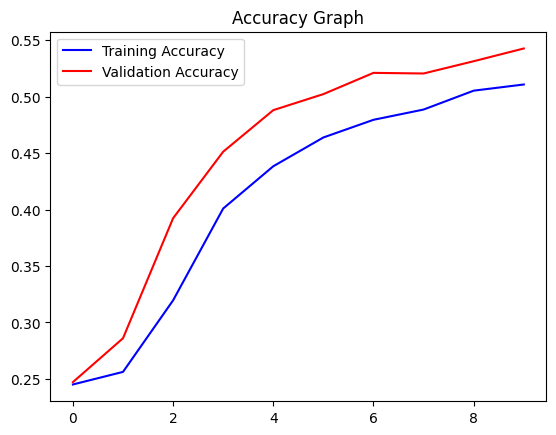

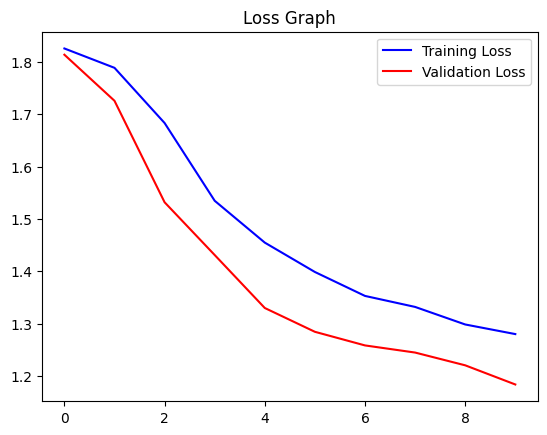

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Test with Image Data

Original Output: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Output: neutral


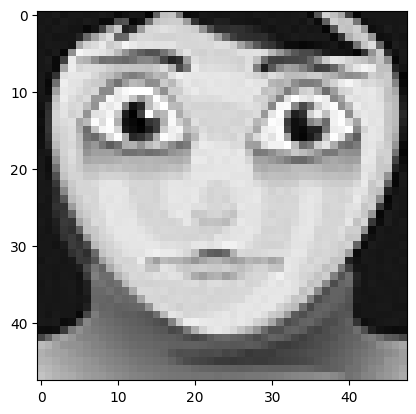

In [24]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Output: surprise


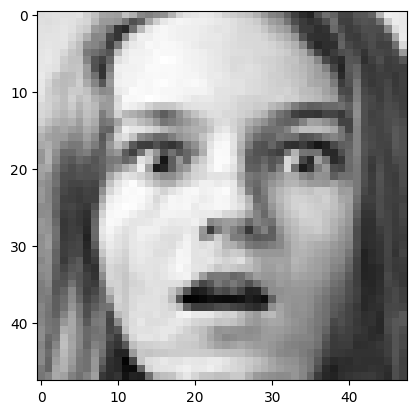

In [25]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Output: neutral


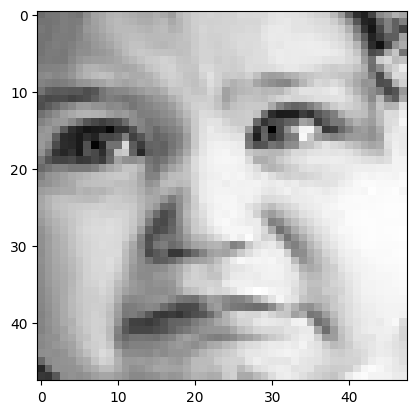

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');